In [1]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

23/06/11 14:39:17 WARN Utils: Your hostname, Jeevas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.20.20.191 instead (on interface en0)
23/06/11 14:39:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/11 14:39:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# path config
data_path = 'data'

In [4]:
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

In [5]:
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [6]:
ratings.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
+------+-------+------+----------+
only showing top 3 rows



In [7]:
links.show(3)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
+-------+------+------+
only showing top 3 rows



In [8]:
tags.show(3)

+------+-------+-----------+----------+
|userId|movieId|        tag| timestamp|
+------+-------+-----------+----------+
|     3|    260|    classic|1439472355|
|     3|    260|     sci-fi|1439472256|
|     4|   1732|dark comedy|1573943598|
+------+-------+-----------+----------+
only showing top 3 rows



In [9]:
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [10]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [11]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

10298 out of 59047 movies are rated by only one user


In [12]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 162541 distinct users in the data sets


In [13]:
tmp = movies.select('movieID').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 62423 distinct movies in the data sets


In [14]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 59047 distinct movies that are rated by users in ratings table
We have 3376 movies that are not rated yet


In [15]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT movieId, title "
    "FROM movies "
    "WHERE movieId NOT IN (SELECT distinct(movieId) FROM ratings)"
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List movies that are not rated yet: 


+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|  25817|Break of Hearts (...|
|  26361|Baby Blue Marine ...|
|  52696|Thousand and One ...|
|  56513|Suicide Killers (...|
|  58209|Alex in Wonder (S...|
|  69864|   Blue Blood (2006)|
|  70312|Family Secret, A ...|
|  71355|February (Khumpha...|
|  73447|I Live My Life (1...|
|  77362|Texas Carnival (1...|
+-------+--------------------+
only showing top 10 rows



In [16]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



In [31]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama|25606|
|            Comedy|16870|
|          Thriller| 8654|
|           Romance| 7719|
|            Action| 7348|
|            Horror| 5989|
|       Documentary| 5605|
|             Crime| 5319|
|(no genres listed)| 5062|
|         Adventure| 4145|
|            Sci-Fi| 3595|
|          Children| 2935|
|         Animation| 2929|
|           Mystery| 2925|
|           Fantasy| 2731|
|               War| 1874|
|           Western| 1399|
|           Musical| 1054|
|         Film-Noir|  353|
|              IMAX|  195|
+------------------+-----+



In [17]:
# load data
movie_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)


23/06/11 14:41:41 WARN BlockManager: Task 159 already completed, not releasing lock for rdd_160_0


[(1, 296, 5.0), (1, 306, 3.5), (1, 307, 5.0)]

In [18]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[164] at RDD at PythonRDD.scala:53

In [19]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model


In [20]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

23/06/11 14:42:42 WARN BlockManager: Task 160 already completed, not releasing lock for rdd_162_0


23/06/11 14:42:46 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 64 (TID 161): Attempting to kill Python Worker


23/06/11 14:42:50 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 65 (TID 162): Attempting to kill Python Worker


23/06/11 14:43:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/11 14:43:15 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/06/11 14:43:15 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/06/11 14:43:15 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


23/06/11 14:43:24 WARN BlockManager: Task 518 already completed, not releasing lock for rdd_163_0


8 latent factors and regularization = 0.001: validation RMSE is 0.8434526116027775
23/06/11 14:44:00 WARN BlockManager: Task 639 already completed, not releasing lock for rdd_162_0


23/06/11 14:44:04 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 243 (TID 640): Attempting to kill Python Worker


23/06/11 14:44:08 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 244 (TID 641): Attempting to kill Python Worker


23/06/11 14:44:34 WARN BlockManager: Task 997 already completed, not releasing lock for rdd_163_0


8 latent factors and regularization = 0.01: validation RMSE is 0.8174282107226266
23/06/11 14:45:08 WARN BlockManager: Task 1118 already completed, not releasing lock for rdd_162_0


23/06/11 14:45:13 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 422 (TID 1119): Attempting to kill Python Worker


23/06/11 14:45:17 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 423 (TID 1120): Attempting to kill Python Worker


23/06/11 14:45:43 WARN BlockManager: Task 1476 already completed, not releasing lock for rdd_163_0


8 latent factors and regularization = 0.05: validation RMSE is 0.8012527547550801
23/06/11 14:46:20 WARN BlockManager: Task 1597 already completed, not releasing lock for rdd_162_0


23/06/11 14:46:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 601 (TID 1598): Attempting to kill Python Worker


23/06/11 14:46:28 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 602 (TID 1599): Attempting to kill Python Worker


23/06/11 14:46:54 WARN BlockManager: Task 1955 already completed, not releasing lock for rdd_163_0


8 latent factors and regularization = 0.1: validation RMSE is 0.8081993180519875
23/06/11 14:47:30 WARN BlockManager: Task 2076 already completed, not releasing lock for rdd_162_0


23/06/11 14:47:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 780 (TID 2077): Attempting to kill Python Worker


23/06/11 14:47:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 781 (TID 2078): Attempting to kill Python Worker


23/06/11 14:48:04 WARN BlockManager: Task 2434 already completed, not releasing lock for rdd_163_0


8 latent factors and regularization = 0.2: validation RMSE is 0.8565403896726091
23/06/11 14:48:41 WARN BlockManager: Task 2555 already completed, not releasing lock for rdd_162_0


23/06/11 14:48:45 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 959 (TID 2556): Attempting to kill Python Worker


23/06/11 14:48:49 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 960 (TID 2557): Attempting to kill Python Worker


23/06/11 14:49:18 WARN BlockManager: Task 2913 already completed, not releasing lock for rdd_163_0


10 latent factors and regularization = 0.001: validation RMSE is 0.8520118387487094
23/06/11 14:49:55 WARN BlockManager: Task 3034 already completed, not releasing lock for rdd_162_0


23/06/11 14:49:59 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1138 (TID 3035): Attempting to kill Python Worker


23/06/11 14:50:03 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1139 (TID 3036): Attempting to kill Python Worker


23/06/11 14:50:34 WARN BlockManager: Task 3392 already completed, not releasing lock for rdd_163_0


10 latent factors and regularization = 0.01: validation RMSE is 0.8179102012492919
23/06/11 14:51:11 WARN BlockManager: Task 3513 already completed, not releasing lock for rdd_162_0


23/06/11 14:51:15 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1317 (TID 3514): Attempting to kill Python Worker


23/06/11 14:51:19 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1318 (TID 3515): Attempting to kill Python Worker


10 latent factors and regularization = 0.05: validation RMSE is 0.7953406388073654
23/06/11 14:52:37 WARN BlockManager: Task 3992 already completed, not releasing lock for rdd_162_0


23/06/11 14:52:41 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1496 (TID 3993): Attempting to kill Python Worker


23/06/11 14:52:45 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1497 (TID 3994): Attempting to kill Python Worker


23/06/11 14:53:18 WARN BlockManager: Task 4350 already completed, not releasing lock for rdd_163_0


10 latent factors and regularization = 0.1: validation RMSE is 0.8046930637103072
23/06/11 14:54:01 WARN BlockManager: Task 4471 already completed, not releasing lock for rdd_162_0


23/06/11 14:54:05 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1675 (TID 4472): Attempting to kill Python Worker


23/06/11 14:54:09 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1676 (TID 4473): Attempting to kill Python Worker


23/06/11 14:56:35 WARN BlockManager: Task 4829 already completed, not releasing lock for rdd_163_0


10 latent factors and regularization = 0.2: validation RMSE is 0.8562672863191645
23/06/11 14:59:02 WARN BlockManager: Task 4950 already completed, not releasing lock for rdd_162_0


23/06/11 14:59:07 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1854 (TID 4951): Attempting to kill Python Worker


23/06/11 14:59:11 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 1855 (TID 4952): Attempting to kill Python Worker


23/06/11 14:59:59 WARN BlockManager: Task 5308 already completed, not releasing lock for rdd_163_0


12 latent factors and regularization = 0.001: validation RMSE is 0.8611191753404317
23/06/11 15:00:50 WARN BlockManager: Task 5429 already completed, not releasing lock for rdd_162_0


23/06/11 15:00:54 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2033 (TID 5430): Attempting to kill Python Worker


23/06/11 15:00:58 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2034 (TID 5431): Attempting to kill Python Worker


23/06/11 15:01:49 WARN BlockManager: Task 5787 already completed, not releasing lock for rdd_163_0


12 latent factors and regularization = 0.01: validation RMSE is 0.8219339365248153
23/06/11 15:02:43 WARN BlockManager: Task 5908 already completed, not releasing lock for rdd_162_0


23/06/11 15:02:47 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2212 (TID 5909): Attempting to kill Python Worker


23/06/11 15:02:51 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2213 (TID 5910): Attempting to kill Python Worker


23/06/11 15:22:40 WARN BlockManager: Task 6266 already completed, not releasing lock for rdd_163_0


12 latent factors and regularization = 0.05: validation RMSE is 0.7970298334270259
23/06/11 15:23:40 WARN BlockManager: Task 6387 already completed, not releasing lock for rdd_162_0


23/06/11 15:23:44 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2391 (TID 6388): Attempting to kill Python Worker


23/06/11 15:23:48 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2392 (TID 6389): Attempting to kill Python Worker


23/06/11 15:24:39 WARN BlockManager: Task 6745 already completed, not releasing lock for rdd_163_0


12 latent factors and regularization = 0.1: validation RMSE is 0.8079978162072754
23/06/11 15:25:34 WARN BlockManager: Task 6866 already completed, not releasing lock for rdd_162_0


23/06/11 15:25:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2570 (TID 6867): Attempting to kill Python Worker


23/06/11 15:25:42 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2571 (TID 6868): Attempting to kill Python Worker


23/06/11 15:26:33 WARN BlockManager: Task 7224 already completed, not releasing lock for rdd_163_0


12 latent factors and regularization = 0.2: validation RMSE is 0.858060274894456
23/06/11 15:27:27 WARN BlockManager: Task 7345 already completed, not releasing lock for rdd_162_0


23/06/11 15:27:31 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2749 (TID 7346): Attempting to kill Python Worker


23/06/11 15:27:35 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2750 (TID 7347): Attempting to kill Python Worker


23/06/11 15:28:35 WARN BlockManager: Task 7703 already completed, not releasing lock for rdd_163_0


14 latent factors and regularization = 0.001: validation RMSE is 0.8730222841698259
23/06/11 15:29:30 WARN BlockManager: Task 7824 already completed, not releasing lock for rdd_162_0


23/06/11 15:29:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2928 (TID 7825): Attempting to kill Python Worker


23/06/11 15:29:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 2929 (TID 7826): Attempting to kill Python Worker


23/06/11 15:30:29 WARN BlockManager: Task 8182 already completed, not releasing lock for rdd_163_0


14 latent factors and regularization = 0.01: validation RMSE is 0.8266796520629642
23/06/11 15:31:50 WARN BlockManager: Task 8303 already completed, not releasing lock for rdd_162_0


23/06/11 15:31:54 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3107 (TID 8304): Attempting to kill Python Worker


23/06/11 15:31:58 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3108 (TID 8305): Attempting to kill Python Worker


23/06/11 15:32:50 WARN BlockManager: Task 8661 already completed, not releasing lock for rdd_163_0


14 latent factors and regularization = 0.05: validation RMSE is 0.7941801022853079
23/06/11 15:33:53 WARN BlockManager: Task 8782 already completed, not releasing lock for rdd_162_0


23/06/11 15:33:57 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3286 (TID 8783): Attempting to kill Python Worker


23/06/11 15:34:01 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3287 (TID 8784): Attempting to kill Python Worker


23/06/11 15:34:50 WARN BlockManager: Task 9140 already completed, not releasing lock for rdd_163_0


14 latent factors and regularization = 0.1: validation RMSE is 0.8073001261216597
23/06/11 15:35:44 WARN BlockManager: Task 9261 already completed, not releasing lock for rdd_162_0


23/06/11 15:35:48 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3465 (TID 9262): Attempting to kill Python Worker


23/06/11 15:35:52 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3466 (TID 9263): Attempting to kill Python Worker


23/06/11 15:36:43 WARN BlockManager: Task 9619 already completed, not releasing lock for rdd_163_0


14 latent factors and regularization = 0.2: validation RMSE is 0.8580533223736345
23/06/11 15:37:35 WARN BlockManager: Task 9740 already completed, not releasing lock for rdd_162_0


23/06/11 15:37:39 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3644 (TID 9741): Attempting to kill Python Worker


23/06/11 15:37:43 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3645 (TID 9742): Attempting to kill Python Worker


23/06/11 15:38:35 WARN BlockManager: Task 10098 already completed, not releasing lock for rdd_163_0


16 latent factors and regularization = 0.001: validation RMSE is 0.8866868233083589
23/06/11 15:39:29 WARN BlockManager: Task 10219 already completed, not releasing lock for rdd_162_0


23/06/11 15:39:33 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3823 (TID 10220): Attempting to kill Python Worker


23/06/11 15:39:37 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 3824 (TID 10221): Attempting to kill Python Worker


23/06/11 15:40:31 WARN BlockManager: Task 10577 already completed, not releasing lock for rdd_163_0


16 latent factors and regularization = 0.01: validation RMSE is 0.8305173189392097
23/06/11 15:41:26 WARN BlockManager: Task 10698 already completed, not releasing lock for rdd_162_0


23/06/11 15:41:30 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4002 (TID 10699): Attempting to kill Python Worker


23/06/11 15:41:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4003 (TID 10700): Attempting to kill Python Worker


23/06/11 15:42:25 WARN BlockManager: Task 11056 already completed, not releasing lock for rdd_163_0


16 latent factors and regularization = 0.05: validation RMSE is 0.7908991932525834
23/06/11 15:43:19 WARN BlockManager: Task 11177 already completed, not releasing lock for rdd_162_0


23/06/11 15:43:23 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4181 (TID 11178): Attempting to kill Python Worker


23/06/11 15:43:27 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4182 (TID 11179): Attempting to kill Python Worker


23/06/11 15:44:24 WARN BlockManager: Task 11535 already completed, not releasing lock for rdd_163_0


16 latent factors and regularization = 0.1: validation RMSE is 0.803866754512132
23/06/11 15:45:20 WARN BlockManager: Task 11656 already completed, not releasing lock for rdd_162_0


23/06/11 15:45:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4360 (TID 11657): Attempting to kill Python Worker


23/06/11 15:45:28 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4361 (TID 11658): Attempting to kill Python Worker


23/06/11 15:46:27 WARN BlockManager: Task 12014 already completed, not releasing lock for rdd_163_0


16 latent factors and regularization = 0.2: validation RMSE is 0.8567577994617005
23/06/11 15:47:18 WARN BlockManager: Task 12135 already completed, not releasing lock for rdd_162_0


23/06/11 15:47:22 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4539 (TID 12136): Attempting to kill Python Worker


23/06/11 15:47:26 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4540 (TID 12137): Attempting to kill Python Worker


23/06/11 15:48:23 WARN BlockManager: Task 12493 already completed, not releasing lock for rdd_163_0


18 latent factors and regularization = 0.001: validation RMSE is 0.8955160916883946
23/06/11 15:49:14 WARN BlockManager: Task 12614 already completed, not releasing lock for rdd_162_0


23/06/11 15:49:18 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4718 (TID 12615): Attempting to kill Python Worker


23/06/11 15:49:22 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4719 (TID 12616): Attempting to kill Python Worker


23/06/11 15:50:22 WARN BlockManager: Task 12972 already completed, not releasing lock for rdd_163_0


18 latent factors and regularization = 0.01: validation RMSE is 0.8349364528663967
23/06/11 15:51:14 WARN BlockManager: Task 13093 already completed, not releasing lock for rdd_162_0


23/06/11 15:51:19 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4897 (TID 13094): Attempting to kill Python Worker


23/06/11 15:51:23 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4898 (TID 13095): Attempting to kill Python Worker


23/06/11 15:52:25 WARN BlockManager: Task 13451 already completed, not releasing lock for rdd_163_0


18 latent factors and regularization = 0.05: validation RMSE is 0.7890067094413719
23/06/11 15:54:25 WARN BlockManager: Task 13572 already completed, not releasing lock for rdd_162_0


23/06/11 15:54:29 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5076 (TID 13573): Attempting to kill Python Worker


23/06/11 15:54:33 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5077 (TID 13574): Attempting to kill Python Worker


23/06/11 15:55:36 WARN BlockManager: Task 13930 already completed, not releasing lock for rdd_163_0


18 latent factors and regularization = 0.1: validation RMSE is 0.8028792588324359
23/06/11 15:56:36 WARN BlockManager: Task 14051 already completed, not releasing lock for rdd_162_0


23/06/11 15:56:40 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5255 (TID 14052): Attempting to kill Python Worker


23/06/11 15:56:44 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5256 (TID 14053): Attempting to kill Python Worker


23/06/11 15:57:45 WARN BlockManager: Task 14409 already completed, not releasing lock for rdd_163_0


18 latent factors and regularization = 0.2: validation RMSE is 0.8565144871607143
23/06/11 15:58:40 WARN BlockManager: Task 14530 already completed, not releasing lock for rdd_162_0


23/06/11 15:58:44 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5434 (TID 14531): Attempting to kill Python Worker


23/06/11 15:58:48 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5435 (TID 14532): Attempting to kill Python Worker


23/06/11 15:59:54 WARN BlockManager: Task 14888 already completed, not releasing lock for rdd_163_0


20 latent factors and regularization = 0.001: validation RMSE is 0.9067255458727291
23/06/11 16:00:48 WARN BlockManager: Task 15009 already completed, not releasing lock for rdd_162_0


23/06/11 16:00:52 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5613 (TID 15010): Attempting to kill Python Worker


23/06/11 16:00:56 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5614 (TID 15011): Attempting to kill Python Worker


23/06/11 16:02:06 WARN BlockManager: Task 15367 already completed, not releasing lock for rdd_163_0


20 latent factors and regularization = 0.01: validation RMSE is 0.8410008132106679
23/06/11 16:03:52 WARN BlockManager: Task 15488 already completed, not releasing lock for rdd_162_0


23/06/11 16:03:56 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5792 (TID 15489): Attempting to kill Python Worker


23/06/11 16:04:00 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5793 (TID 15490): Attempting to kill Python Worker


23/06/11 16:05:14 WARN BlockManager: Task 15846 already completed, not releasing lock for rdd_163_0


20 latent factors and regularization = 0.05: validation RMSE is 0.7916848451667952
23/06/11 16:06:10 WARN BlockManager: Task 15967 already completed, not releasing lock for rdd_162_0


23/06/11 16:06:14 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5971 (TID 15968): Attempting to kill Python Worker


23/06/11 16:06:18 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5972 (TID 15969): Attempting to kill Python Worker


23/06/11 16:07:22 WARN BlockManager: Task 16325 already completed, not releasing lock for rdd_163_0


20 latent factors and regularization = 0.1: validation RMSE is 0.8067683627510605
23/06/11 16:08:16 WARN BlockManager: Task 16446 already completed, not releasing lock for rdd_162_0


23/06/11 16:08:20 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6150 (TID 16447): Attempting to kill Python Worker


23/06/11 16:08:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6151 (TID 16448): Attempting to kill Python Worker


23/06/11 16:09:26 WARN BlockManager: Task 16804 already completed, not releasing lock for rdd_163_0


20 latent factors and regularization = 0.2: validation RMSE is 0.8584049059243941

The best model has 18 latent factors and regularization = 0.05
Total Runtime: 5263.16 seconds


In [21]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

23/06/11 21:54:01 WARN BlockManager: Task 16925 already completed, not releasing lock for rdd_162_0


23/06/11 21:54:05 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6329 (TID 16926): Attempting to kill Python Worker


23/06/11 21:54:09 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6330 (TID 16927): Attempting to kill Python Worker


23/06/11 21:55:03 WARN BlockManager: Task 17067 already completed, not releasing lock for rdd_163_0


23/06/11 21:55:56 WARN BlockManager: Task 17188 already completed, not releasing lock for rdd_162_0


23/06/11 21:56:00 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6382 (TID 17189): Attempting to kill Python Worker


23/06/11 21:56:04 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6383 (TID 17190): Attempting to kill Python Worker


23/06/11 21:56:41 WARN BlockManager: Task 17354 already completed, not releasing lock for rdd_163_0


23/06/11 21:57:34 WARN BlockManager: Task 17475 already completed, not releasing lock for rdd_162_0


23/06/11 21:57:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6449 (TID 17476): Attempting to kill Python Worker


23/06/11 21:57:42 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6450 (TID 17477): Attempting to kill Python Worker


23/06/11 21:58:15 WARN BlockManager: Task 17665 already completed, not releasing lock for rdd_163_0


23/06/11 21:59:08 WARN BlockManager: Task 17786 already completed, not releasing lock for rdd_162_0


23/06/11 21:59:13 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6530 (TID 17787): Attempting to kill Python Worker


23/06/11 21:59:17 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6531 (TID 17788): Attempting to kill Python Worker


23/06/11 22:00:00 WARN BlockManager: Task 18000 already completed, not releasing lock for rdd_163_0


23/06/11 22:00:53 WARN BlockManager: Task 18121 already completed, not releasing lock for rdd_162_0


23/06/11 22:00:57 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6625 (TID 18122): Attempting to kill Python Worker


23/06/11 22:01:02 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6626 (TID 18123): Attempting to kill Python Worker


23/06/11 22:01:43 WARN BlockManager: Task 18359 already completed, not releasing lock for rdd_163_0


23/06/11 22:02:37 WARN BlockManager: Task 18480 already completed, not releasing lock for rdd_162_0


23/06/11 22:02:41 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6734 (TID 18481): Attempting to kill Python Worker


23/06/11 22:02:45 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6735 (TID 18482): Attempting to kill Python Worker


23/06/11 22:03:35 WARN BlockManager: Task 18742 already completed, not releasing lock for rdd_163_0


23/06/11 22:04:33 WARN BlockManager: Task 18863 already completed, not releasing lock for rdd_162_0


23/06/11 22:04:37 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6857 (TID 18864): Attempting to kill Python Worker


23/06/11 22:04:41 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6858 (TID 18865): Attempting to kill Python Worker


23/06/11 22:05:33 WARN BlockManager: Task 19149 already completed, not releasing lock for rdd_163_0


23/06/11 22:06:26 WARN BlockManager: Task 19270 already completed, not releasing lock for rdd_162_0


23/06/11 22:06:30 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6994 (TID 19271): Attempting to kill Python Worker


23/06/11 22:06:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 6995 (TID 19272): Attempting to kill Python Worker


23/06/11 22:07:31 WARN BlockManager: Task 19580 already completed, not releasing lock for rdd_163_0


23/06/11 22:08:26 WARN BlockManager: Task 19701 already completed, not releasing lock for rdd_162_0


23/06/11 22:08:30 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7145 (TID 19702): Attempting to kill Python Worker


23/06/11 22:08:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7146 (TID 19703): Attempting to kill Python Worker


23/06/11 22:09:34 WARN BlockManager: Task 20035 already completed, not releasing lock for rdd_163_0


23/06/11 22:10:30 WARN BlockManager: Task 20156 already completed, not releasing lock for rdd_162_0


23/06/11 22:10:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7310 (TID 20157): Attempting to kill Python Worker


23/06/11 22:10:38 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7311 (TID 20158): Attempting to kill Python Worker


23/06/11 22:11:44 WARN BlockManager: Task 20514 already completed, not releasing lock for rdd_163_0


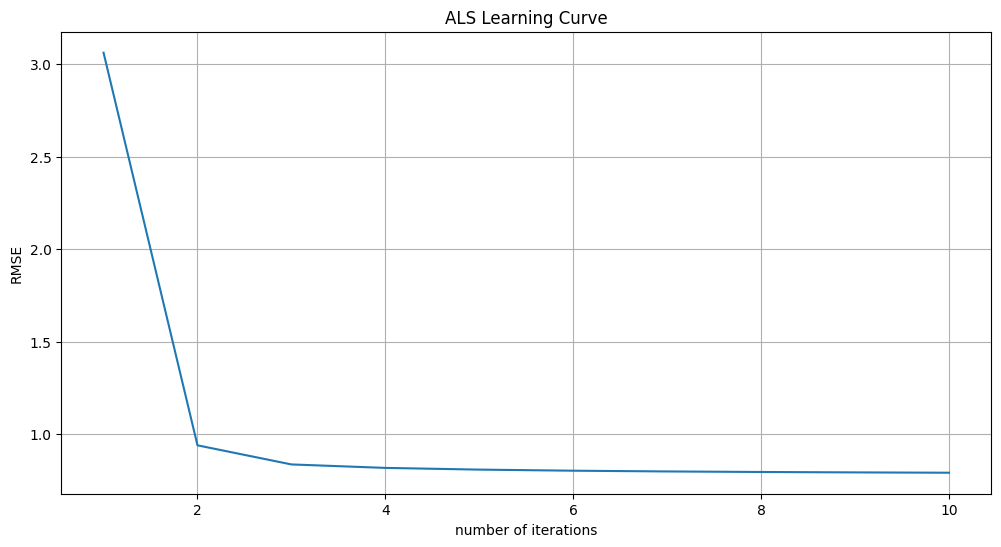

In [22]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

In [23]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

23/06/11 22:51:21 WARN BlockManager: Task 20635 already completed, not releasing lock for rdd_164_0


The out-of-sample RMSE of rating predictions is 0.7889


In [24]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [25]:
# my favorite movies
my_favorite_movies = ['Iron Man']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

23/06/11 22:52:54 WARN BlockManager: Task 20799 already completed, not releasing lock for rdd_160_0


23/06/11 22:52:58 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7521 (TID 20800): Attempting to kill Python Worker


23/06/11 22:53:02 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 7522 (TID 20801): Attempting to kill Python Worker


Recommendations for Iron Man:
1: Thousand Clouds of Peace, A (Mil nubes de paz cercan el cielo, amor, jamás acabarás de ser amor) (2003)
2: Misérables, Les (1934)
3: Deathstalker II (1987)
4: Gurren Lagann: Childhood's End (Gekijô ban Tengen toppa guren ragan: Guren hen) (2008)
5: "Diebuster ""Top wo Narae 2"" (2004)"
6: National Theatre Live: Frankenstein (2011)
7: Final (2001)
8: Motherland (2015)
9: My Future Love (2016)
10: Dara O'Briain Crowd Tickler (2015)


23/06/11 23:06:49 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 277731 ms exceeds timeout 120000 ms
23/06/11 23:06:49 WARN SparkContext: Killing executors is not supported by current scheduler.
23/06/11 23:06:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B